In [ ]:
!pip install requests


In [ ]:
import requests

def download_zip(url, local_filename):
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(local_filename, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)
    return local_filename

In [ ]:
import zipfile

def list_zip_contents(zip_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        return zip_ref.namelist()

In [ ]:
import os

def extract_files(zip_path, file_list, extract_to='.'):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        for file in file_list:
            zip_ref.extract(file, path=extract_to)

In [ ]:
zip_url = 'https://vision.eng.au.dk/?download=/data/GrassClover/raw_images.zip'
local_zip_path = 'large_dataset.zip'

# Download the ZIP file
download_zip(zip_url, local_zip_path)

KeyboardInterrupt: 

In [ ]:
import requests
import struct
from io import BytesIO

def fetch_zip_headers(url, byte_range=65536):
    headers = {'Range': f'bytes=0-{byte_range}'}
    response = requests.get(url, headers=headers, stream=True)
    response.raise_for_status()
    return BytesIO(response.content)

def list_zip_contents(zip_headers):
    central_dir_signature = b'\x50\x4b\x01\x02'
    zip_headers.seek(0, 2)
    end_of_file = zip_headers.tell()
    zip_headers.seek(0)

    contents = []
    while zip_headers.tell() < end_of_file:
        data = zip_headers.read(4)
        if data == central_dir_signature:
            zip_headers.read(2)  # skip version made by
            zip_headers.read(2)  # skip version needed to extract
            zip_headers.read(2)  # skip general purpose bit flag
            zip_headers.read(2)  # skip compression method
            zip_headers.read(2)  # skip last mod file time
            zip_headers.read(2)  # skip last mod file date
            zip_headers.read(4)  # skip crc-32
            zip_headers.read(4)  # skip compressed size
            zip_headers.read(4)  # skip uncompressed size
            file_name_length = struct.unpack('<H', zip_headers.read(2))[0]
            extra_field_length = struct.unpack('<H', zip_headers.read(2))[0]
            file_comment_length = struct.unpack('<H', zip_headers.read(2))[0]
            zip_headers.read(2)  # skip disk number start
            zip_headers.read(2)  # skip internal file attributes
            zip_headers.read(4)  # skip external file attributes
            zip_headers.read(4)  # skip relative offset of local header
            file_name = zip_headers.read(file_name_length).decode('utf-8')
            contents.append(file_name)
            zip_headers.read(extra_field_length + file_comment_length)  # skip extra field and file comment
        else:
            zip_headers.seek(zip_headers.tell() - 3)
    return contents

# URL of the large ZIP file
zip_url = 'https://vision.eng.au.dk/?download=/data/GrassClover/raw_images.zip'

# Fetch the ZIP file headers
zip_headers = fetch_zip_headers(zip_url)

# List contents of the ZIP file
zip_contents = list_zip_contents(zip_headers)
print("Contents of the ZIP file:", zip_contents)

KeyboardInterrupt: 

In [ ]:
import requests
import struct
from io import BytesIO

def fetch_eocd_and_cd(url):
    # Fetch the last 500 bytes to ensure we capture the EOCD
    headers = {'Range': 'bytes=-500'}
    response = requests.get(url, headers=headers)
    data = response.content

    # Find the EOCD signature
    eocd_signature = b'PK\x05\x06'
    eocd_offset = data.rfind(eocd_signature)

    if eocd_offset == -1:
        raise Exception("EOCD signature not found")

    # Parse the EOCD to find the Central Directory offset and size
    eocd = data[eocd_offset:]
    cd_size = struct.unpack('<I', eocd[12:16])[0]
    cd_offset = struct.unpack('<I', eocd[16:20])[0]

    # Fetch the Central Directory
    headers = {'Range': f'bytes={cd_offset}-{cd_offset + cd_size}'}
    response = requests.get(url, headers=headers)
    central_directory = response.content

    return central_directory

def list_zip_contents(central_directory):
    cd_signature = b'PK\x01\x02'
    offset = 0
    contents = []
    file_info = {}

    while offset < len(central_directory):
        if central_directory[offset:offset+4] != cd_signature:
            break

        # Read the file header details
        file_name_length = struct.unpack('<H', central_directory[offset+28:offset+30])[0]
        extra_field_length = struct.unpack('<H', central_directory[offset+30:offset+32])[0]
        file_comment_length = struct.unpack('<H', central_directory[offset+32:offset+34])[0]
        file_name = central_directory[offset+46:offset+46+file_name_length].decode('utf-8')

        # Extract file details
        local_header_offset = struct.unpack('<I', central_directory[offset+42:offset+46])[0]

        contents.append(file_name)
        file_info[file_name] = local_header_offset

        # Move to the next file header in the Central Directory
        offset += 46 + file_name_length + extra_field_length + file_comment_length

    return contents, file_info

def download_file_from_zip(url, file_info, file_name, output_path):
    local_header_offset = file_info[file_name]

    # Fetch the local file header
    headers = {'Range': f'bytes={local_header_offset}-{local_header_offset + 30}'}
    response = requests.get(url, headers=headers)
    data = response.content

    # Parse the local file header to get the file data offset and sizes
    lf_signature = b'PK\x03\x04'
    if data[:4] != lf_signature:
        raise Exception("Local file header signature not found")

    compressed_size = struct.unpack('<I', data[18:22])[0]
    uncompressed_size = struct.unpack('<I', data[22:26])[0]
    file_name_length = struct.unpack('<H', data[26:28])[0]
    extra_field_length = struct.unpack('<H', data[28:30])[0]

    file_data_offset = local_header_offset + 30 + file_name_length + extra_field_length

    # Fetch the file data
    headers = {'Range': f'bytes={file_data_offset}-{file_data_offset + compressed_size - 1}'}
    response = requests.get(url, headers=headers)
    file_data = response.content

    # Decompress the file data if necessary
    import zlib
    file_data = zlib.decompress(file_data, -zlib.MAX_WBITS)

    # Save the file data
    with open(output_path, 'wb') as f:
        f.write(file_data)

# URL of the large ZIP file
zip_url = 'https://vision.eng.au.dk/?download=/data/GrassClover/developed_images.zip'

# Fetch the Central Directory
central_directory = fetch_eocd_and_cd(zip_url)

# List contents of the ZIP file
zip_contents, file_info = list_zip_contents(central_directory)
print("Contents of the ZIP file:", zip_contents)

Contents of the ZIP file: []


In [ ]:
from collections import defaultdict

def categorize_files(file_list):
    categorized_files = defaultdict(list)
    for file in file_list:
        file_extension = file.split('.')[-1] if '.' in file else 'no_extension'
        categorized_files[file_extension].append(file)
    return categorized_files

categorized_files = categorize_files(zip_contents)

# Print categorized files
for file_type, files in categorized_files.items():
    print(f"\nFiles with .{file_type} extension:")
    for file in files:
        print(file)

In [ ]:
def download_file_from_zip(url, file_info, file_name, output_path):
    local_header_offset = file_info[file_name]

    # Fetch the local file header and the file data
    headers = {'Range': f'bytes={local_header_offset}-{local_header_offset + 30}'}
    response = requests.get(url, headers=headers)
    data = response.content

    # Parse the local file header to get the file data offset and compressed size
    lf_signature = b'PK\x03\x04'
    if data[:4] != lf_signature:
        raise Exception("Local file header signature not found")

    compressed_size = struct.unpack('<I', data[18:22])[0]
    file_data_offset = local_header_offset + 30 + struct.unpack('<H', data[26:28])[0] + struct.unpack('<H', data[28:30])[0]

    # Fetch the file data
    headers = {'Range': f'bytes={file_data_offset}-{file_data_offset + compressed_size}'}
    response = requests.get(url, headers=headers)
    file_data = response.content

    # Save the file data
    with open(output_path, 'wb') as f:
        f.write(file_data)

In [ ]:
# Files to download
files_to_download = ['test/biomass_test_data.csv', 'train/biomass_train_data.csv']

# Download the specified files
for file_name in files_to_download:
    if file_name in file_info:
        download_file_from_zip(zip_url, file_info, file_name, file_name.split('/')[-1])
        print(f"Downloaded {file_name}")
    else:
        print(f"{file_name} not found in the ZIP archive")

Downloaded test/biomass_test_data.csv
Downloaded train/biomass_train_data.csv


In [ ]:
def replace_semicolons_in_csv(input_file, output_file):
    with open(input_file, 'r') as infile:
        data = infile.read()

    updated_data = data.replace(';', ',')

    with open(output_file, 'w') as outfile:
        outfile.write(updated_data)

# Usage
input_file = '/content/biomass_train_data.csv'
output_file = '/content/biomass_train_data.csv'
replace_semicolons_in_csv(input_file, output_file)

In [ ]:
!pip install onlinezip

In [ ]:
from onlinezip.OnlineZip import OnlineZip

zip = OnlineZip('https://vision.eng.au.dk/?download=/data/GrassClover/synthetic_images.zip')

In [ ]:
print(zip.namelist())
zip.extract('synthetic_class_label_descriptions.txt')



['synthetic_images/', 'synthetic_images/InstanceLabels/', 'synthetic_images/InstanceLabels/B__74f7b807599297dd7e05b604228cd522.png', 'synthetic_images/InstanceLabels/A__de6e449ecd5f05d947ac3e4382337725.png', 'synthetic_images/InstanceLabels/A__7312e48bdc9a8ed298b44484553c4c26.png', 'synthetic_images/InstanceLabels/C__2691587841350219084aa5a02a7d5191.png', 'synthetic_images/InstanceLabels/B__c5430cfbf8dd703b06033920291f535e.png', 'synthetic_images/InstanceLabels/C__7c4baa98088e6a708489876b67f280e0.png', 'synthetic_images/InstanceLabels/C__e5491cc81daa9abebda8100561b2f130.png', 'synthetic_images/InstanceLabels/B__2d57217c174954fd8b6f26c9a1cf0e3c.png', 'synthetic_images/InstanceLabels/D__552b0eb1c3e91a0e63a467321339b0a6.png', 'synthetic_images/InstanceLabels/D__16f2985a94edde02e11c0497b28f8718.png', 'synthetic_images/InstanceLabels/B__2562bb374a62eb78de452e220dda50f2.png', 'synthetic_images/InstanceLabels/A__20dcd916582e4e31333f16400bd87253.png', 'synthetic_images/InstanceLabels/A__392e4e

'/content/synthetic_class_label_descriptions.txt'

In [ ]:
from onlinezip.OnlineZip import OnlineZip

zip = OnlineZip('https://sensor-cdt-group-project.s3.eu-north-1.amazonaws.com/data.zip')

In [ ]:
# print(zip.namelist())
img = zip.extract('content/content/flat_split/Cow Dung_Fran_359_2419_582.jpg')

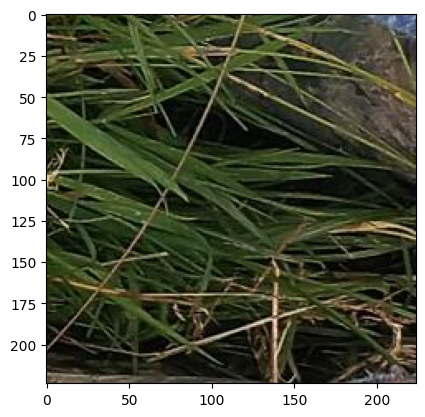

In [ ]:
# prompt: display img (itss the contents of a jpg)

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Read the image data from the zip file
img = zip.extract('content/content/flat_split/Cow Dung_Fran_359_2419_582.jpg')

# Display the image using matplotlib
img = mpimg.imread(img)
imgplot = plt.imshow(img)
plt.show()


In [ ]:
zip_contents = zip.namelist()

categorized_files = categorize_files(zip_contents)

# Print categorized files
for file_type, files in categorized_files.items():
    print(f"\nFiles with .{file_type} extension:")
    if (file_type == 'txt' or file_type == 'no_extension'):
      for file in files:
          print(file)


Files with .no_extension extension:
synthetic_images/
synthetic_images/InstanceLabels/
synthetic_images/ImageLabels/
synthetic_images/Images/

Files with .png extension:

Files with .jpg extension:

Files with .txt extension:
synthetic_class_label_descriptions.txt
